In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import register_matplotlib_converters
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import warnings
import alphakey
warnings.filterwarnings("ignore")

In [2]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED'\
      f'&symbol=AAPL&interval=5min&outputsize=full&apikey={alphakey.key}&datatype=csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)
df = df.sort_index()

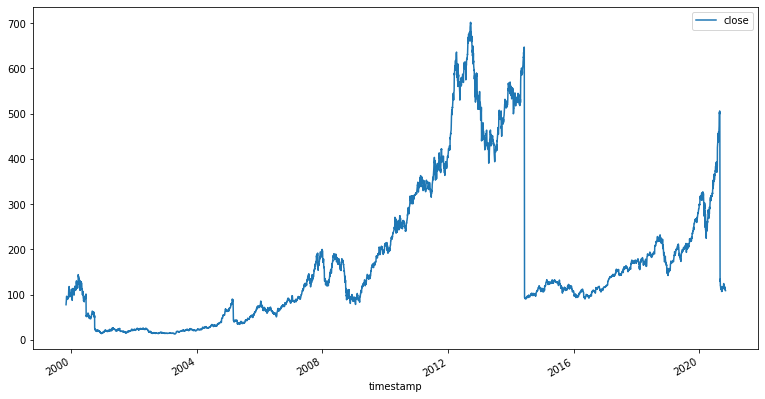

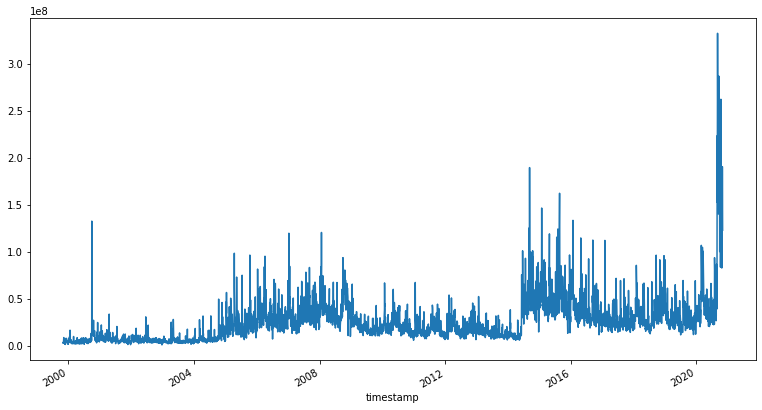

In [5]:
df[['close']].plot(figsize=(13, 7))
plt.show()
df.volume.plot(figsize=(13, 7));

<AxesSubplot:xlabel='timestamp'>

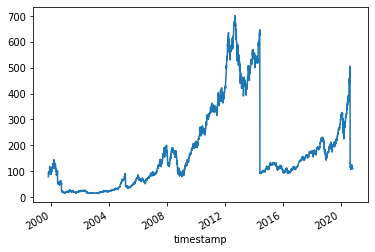

In [6]:
df.close.plot()

In [7]:
modeling_data = df[['close']].copy()

modeling_data = modeling_data.resample('D').asfreq()
modeling_data = modeling_data.bfill()

In [8]:
train = modeling_data['2018']
validate = modeling_data['2019']
test = modeling_data['2020']

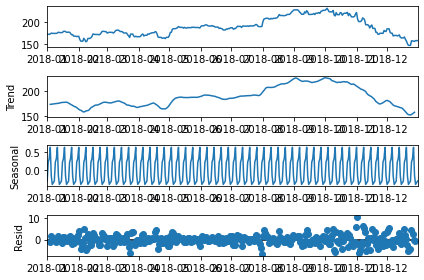

In [9]:
_ = sm.tsa.seasonal_decompose(train).plot()
plt.tight_layout()
plt.show();

In [10]:
def rename_columns(modeling_set):
    modeling_set.rename(columns=({'timestamp': 'ds', 'close': 'y'}), inplace=True)
    return modeling_set

In [11]:
train.reset_index(inplace=True)
validate.reset_index(inplace=True)
test.reset_index(inplace=True)

# to use the growth max and saturating min, we add 2 columns, one for each...
# 'cap' and 'floor' with the respective values
train['cap'] = 250
train['floor'] = 125

# reset index as prophet needs ds to be a column and not an index.
train = rename_columns(train)
validate = rename_columns(validate)
test = rename_columns(test)

m = Prophet(daily_seasonality = False,
            weekly_seasonality = True,
            growth = 'linear',
            changepoint_range = 0.9
)

m.add_country_holidays(country_name='US')
m.fit(train)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [12]:
future = m.make_future_dataframe(periods = len(validate))
future['cap'] = 250
future['floor'] = 125

forecast = m.predict(future)

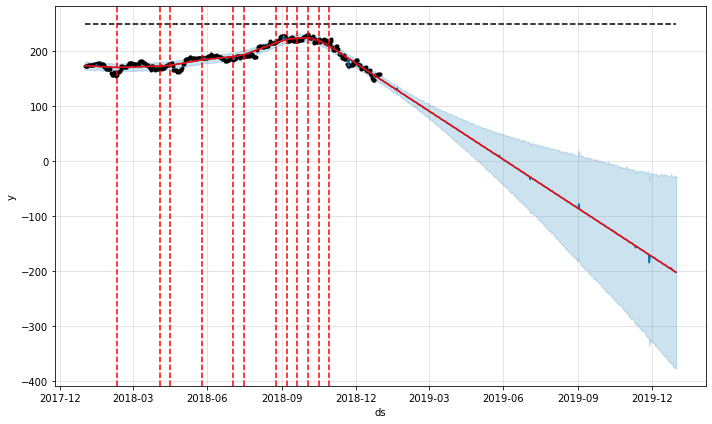

In [13]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [14]:
train

,ds,y,cap,floor
0,2018-01-01,172.26,250,125
1,2018-01-02,172.26,250,125
2,2018-01-03,172.23,250,125
3,2018-01-04,173.03,250,125
4,2018-01-05,175.00,250,125
...,...,...,...,...
360,2018-12-27,156.15,250,125
361,2018-12-28,156.23,250,125
362,2018-12-29,157.74,250,125
363,2018-12-30,157.74,250,125


In [15]:
forecast.head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,173.497518,250,165.657030,180.028860,173.497518,173.497518,0.0,0.0,0.0,...,-0.710252,-0.710252,-0.710252,-0.560526,-0.560526,-0.560526,0.0,0.0,0.0,172.226740
1,2018-01-02,173.416591,250,166.035905,181.031172,173.416591,173.416591,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.083426,0.083426,0.083426,0.0,0.0,0.0,173.500017
2,2018-01-03,173.335664,250,166.141355,180.923154,173.335664,173.335664,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.327384,0.327384,0.327384,0.0,0.0,0.0,173.663048
3,2018-01-04,173.254737,250,166.742793,181.463362,173.254737,173.254737,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.869749,0.869749,0.869749,0.0,0.0,0.0,174.124487
4,2018-01-05,173.173811,250,165.902719,180.072357,173.173811,173.173811,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.164930,-0.164930,-0.164930,0.0,0.0,0.0,173.008880


In [16]:
evaluate_df = pd.merge(train, forecast[['ds', 'yhat']], how ='inner', on ='ds')

rmse = round(sqrt(mean_squared_error(evaluate_df.y, evaluate_df.yhat)), 2)
rmse

5.55

In [17]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY'\
      f'&symbol=AAPL&interval=5min&outputsize=full&apikey={alphakey.key}&datatype=csv'

In [18]:
df = pd.read_csv(url)

In [19]:
df.head()

,timestamp,open,high,low,close,volume
0,2020-11-02 20:00:00,109.12,109.18,109.11,109.13,35955
1,2020-11-02 19:55:00,109.00,109.12,109.00,109.12,25773
2,2020-11-02 19:50:00,108.92,109.00,108.91,109.00,17622
3,2020-11-02 19:45:00,108.88,108.98,108.88,108.92,9703
4,2020-11-02 19:40:00,108.96,108.98,108.92,108.92,20066


In [20]:
df.shape

(4018, 6)

In [21]:
df.timestamp = pd.to_datetime(df.timestamp)
df.set_index('timestamp', inplace=True)
df = df.sort_index()

In [33]:
df = df.resample('5Min').mean().bfill()

In [34]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

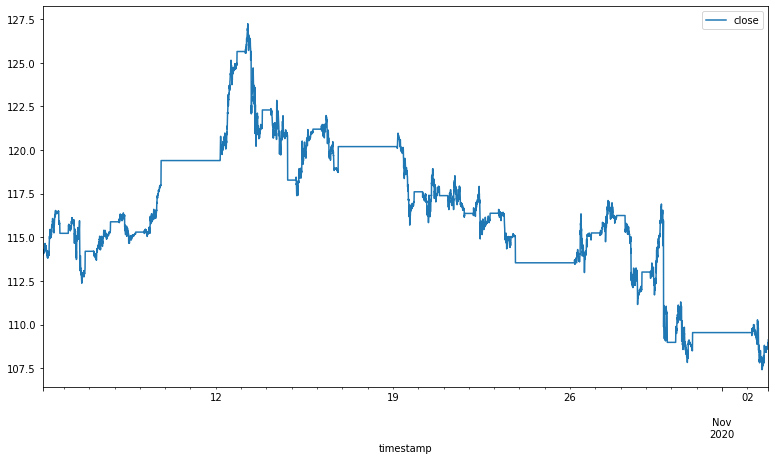

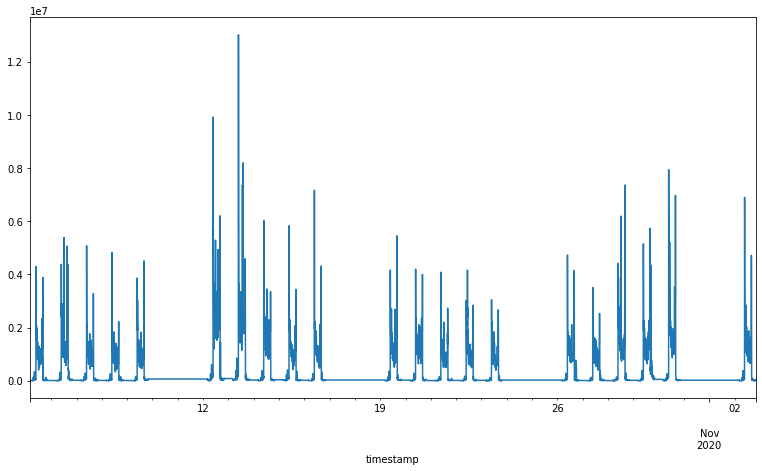

In [35]:
df[['close']].plot(figsize=(13, 7))
plt.show()
df.volume.plot(figsize=(13, 7));

In [36]:
train.reset_index(inplace=True)
validate.reset_index(inplace=True)
test.reset_index(inplace=True)

# to use the growth max and saturating min, we add 2 columns, one for each...
# 'cap' and 'floor' with the respective values
train['cap'] = 140
train['floor'] = 120

# reset index as prophet needs ds to be a column and not an index.
train = rename_columns(train)
validate = rename_columns(validate)
test = rename_columns(test)

m = Prophet(daily_seasonality = False,
            weekly_seasonality = True,
            growth = 'linear',
            changepoint_range = 0.9
)

m.add_country_holidays(country_name='US')
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [37]:
future = m.make_future_dataframe(periods=300, freq='5min')
future['cap'] = 140
future['floor'] = 120

forecast = m.predict(future)

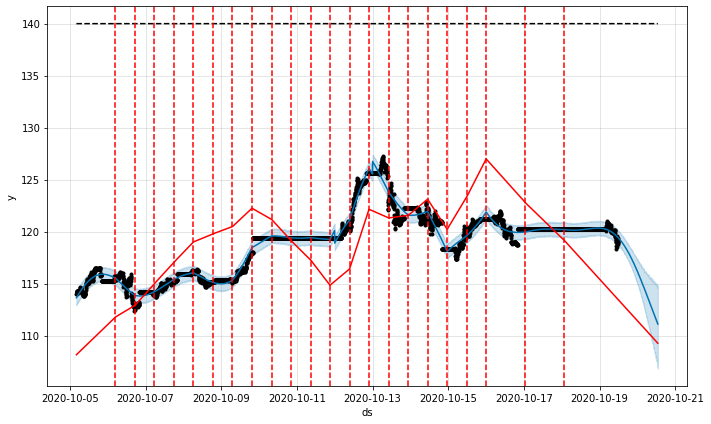

In [38]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [39]:
evaluate_df = pd.merge(train, forecast[['ds', 'yhat']], how ='inner', on ='ds')

rmse = round(sqrt(mean_squared_error(evaluate_df.y, evaluate_df.yhat)), 2)
rmse

0.52